# Predict Future Sales

This challenge serves as final project for the "How to win a data science competition" Coursera course. <br>
<br>
In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. <br>
<br>
<br>
- ID - an Id that represents a (Shop, Item) tuple within the test set <br> <br>
- shop_id - unique identifier of a shop <br> <br>
- item_id - unique identifier of a product<br> <br>
- item_category_id - unique identifier of item category<br> <br>
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure<br> <br>
- item_price - current price of an item<br> <br>
- date - date in format dd/mm/yyyy<br> <br>
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33<br> <br>
- item_name - name of item<br> <br>
- shop_name - name of shop<br> <br>
- item_category_name - name of item category<br> <br>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns 
from tqdm import tqdm 
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error

In [2]:
# Download data

dossier = '/Users/augustincablant/Desktop/Kaggle/'

df_train = pd.read_csv(dossier+'sales_train.csv')

df_test = pd.read_csv(dossier+'test.csv')

items = pd.read_csv(dossier+'items.csv')

item_categories = pd.read_csv(dossier+'item_categories.csv')

shops = pd.read_csv(dossier+'shops.csv')

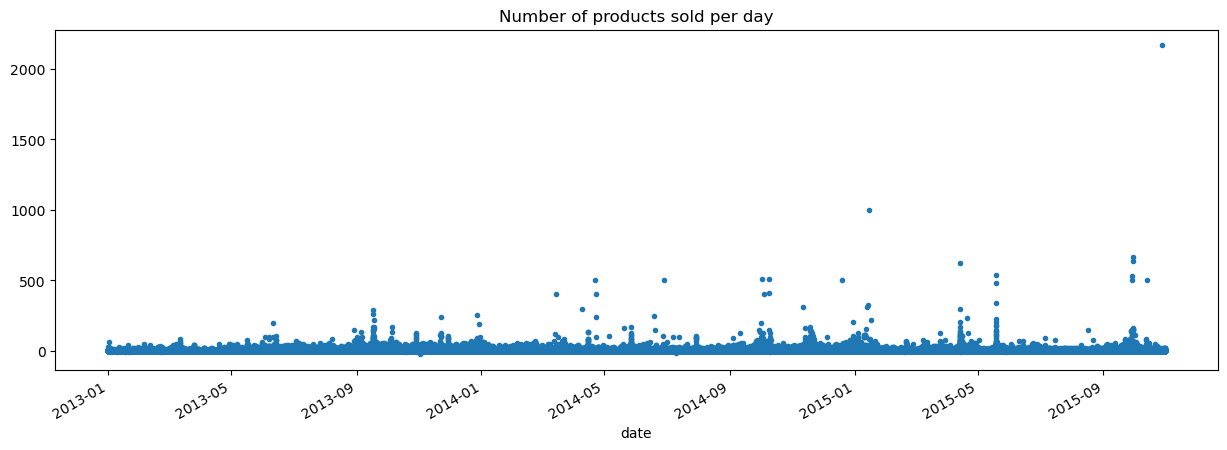

In [7]:
df_train['date'] = pd.to_datetime(df_train['date'], format='%d.%m.%Y')

df_train = df_train.set_index(df_train['date'])

df_train['item_cnt_day'].plot(style='.',
        figsize=(15, 5),
        title='Number of products sold per day')
plt.show()

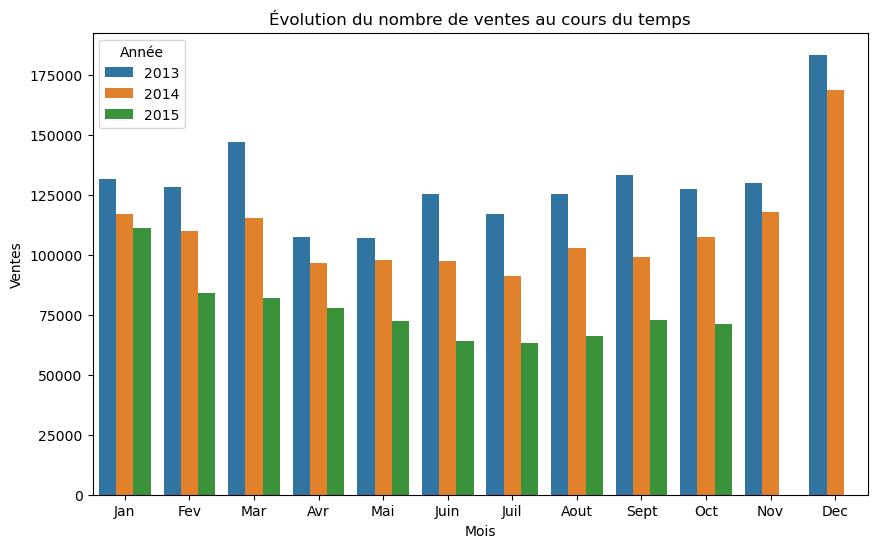

In [8]:
df_train['date'] = df_train.index
df_train['year'] = df_train['date'].dt.year
df_train['mois'] = df_train['date'].dt.month
ventes_par_mois = df_train.groupby(['year', 'mois'])['item_cnt_day'].sum()
ventes_par_mois = ventes_par_mois.reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='mois', y='item_cnt_day', hue='year', data=ventes_par_mois)

# Renommer les étiquettes du mois
mois_labels = ['Jan', 'Fev', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Aout', 'Sept', 'Oct', 'Nov', 'Dec']
plt.xticks(range(12), mois_labels)

plt.xlabel('Mois')
plt.ylabel('Ventes')
plt.title('Évolution du nombre de ventes au cours du temps')
plt.legend(title='Année', loc='upper left')
plt.show()

In [9]:
# get item_category_id
df_train = pd.merge(df_train, items[['item_id', 'item_category_id']], on='item_id', how='left')

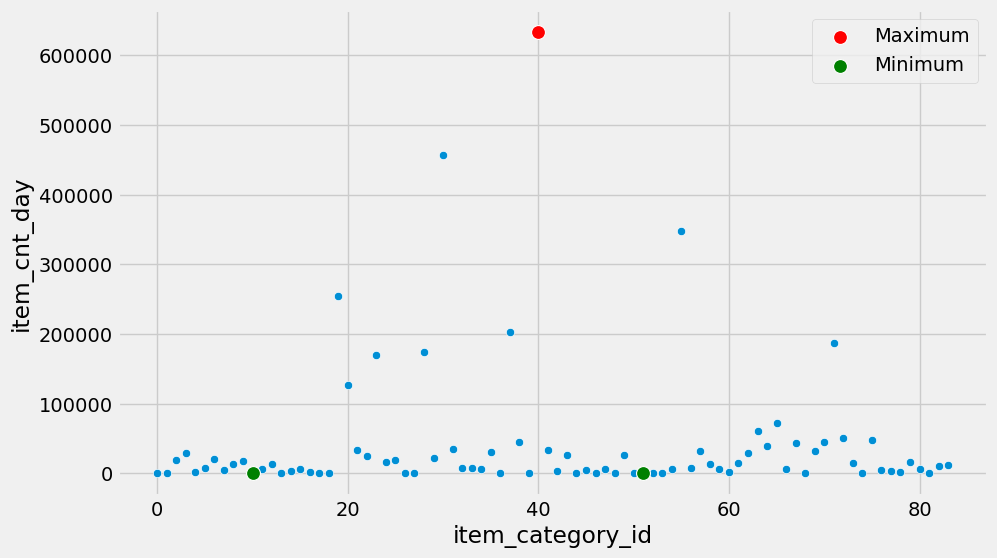

(    item_category_id  item_cnt_day
 40                40      634171.0,
     item_category_id  item_cnt_day
 10                10           1.0
 51                51           1.0)

In [58]:
ventes_par_category = df_train.groupby('item_category_id')['item_cnt_day'].sum()
ventes_par_category = ventes_par_category.reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='item_category_id', y='item_cnt_day', data=ventes_par_category)
sns.scatterplot()

max_points = ventes_par_category[ventes_par_category['item_cnt_day'] == ventes_par_category['item_cnt_day'].max()]
min_points = ventes_par_category[ventes_par_category['item_cnt_day'] == ventes_par_category['item_cnt_day'].min()]

sns.scatterplot(x=max_points['item_category_id'], y=max_points['item_cnt_day'], color='red', label='Maximum', s=100 )
sns.scatterplot(x=min_points['item_category_id'], y=min_points['item_cnt_day'], color='green', label='Minimum', s=100)

plt.show()

max_points, min_points 

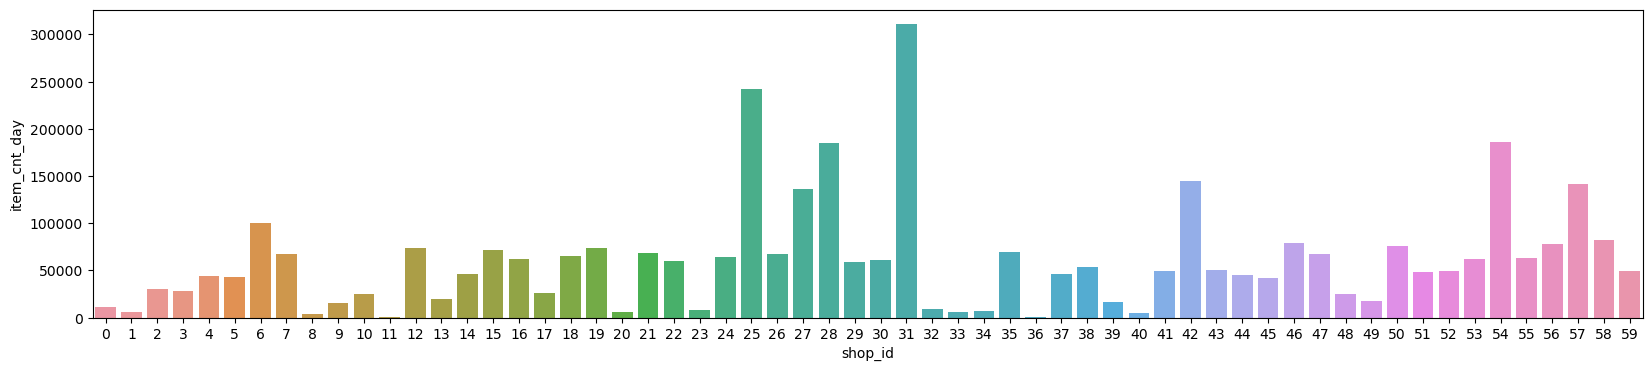

In [10]:
# Shop wise selling
df_train_3 = df_train.groupby(['shop_id'], as_index=False)['item_cnt_day'].sum()
plt.figure(figsize=(20,4))
sns.barplot(x="shop_id",y="item_cnt_day", data=df_train_3)
plt.show()

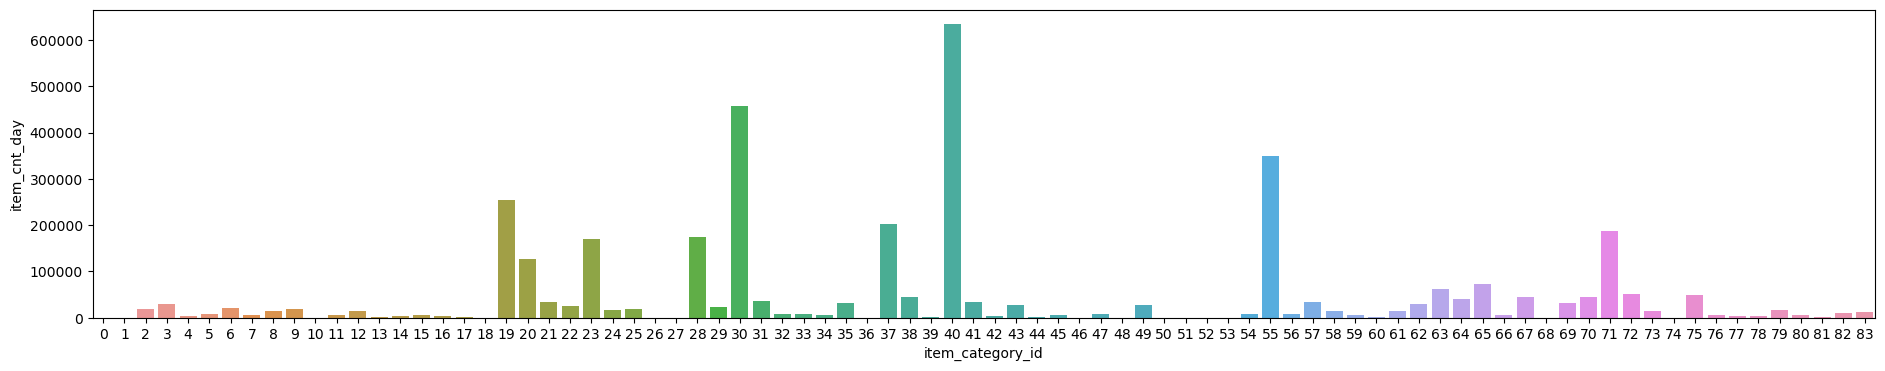

In [11]:
# Item category wise selling
df_train_3 = df_train.groupby(['item_category_id'], as_index=False)['item_cnt_day'].sum()
plt.figure(figsize=(23,4))
sns.barplot(x="item_category_id",y="item_cnt_day", data = df_train_3)
plt.show()

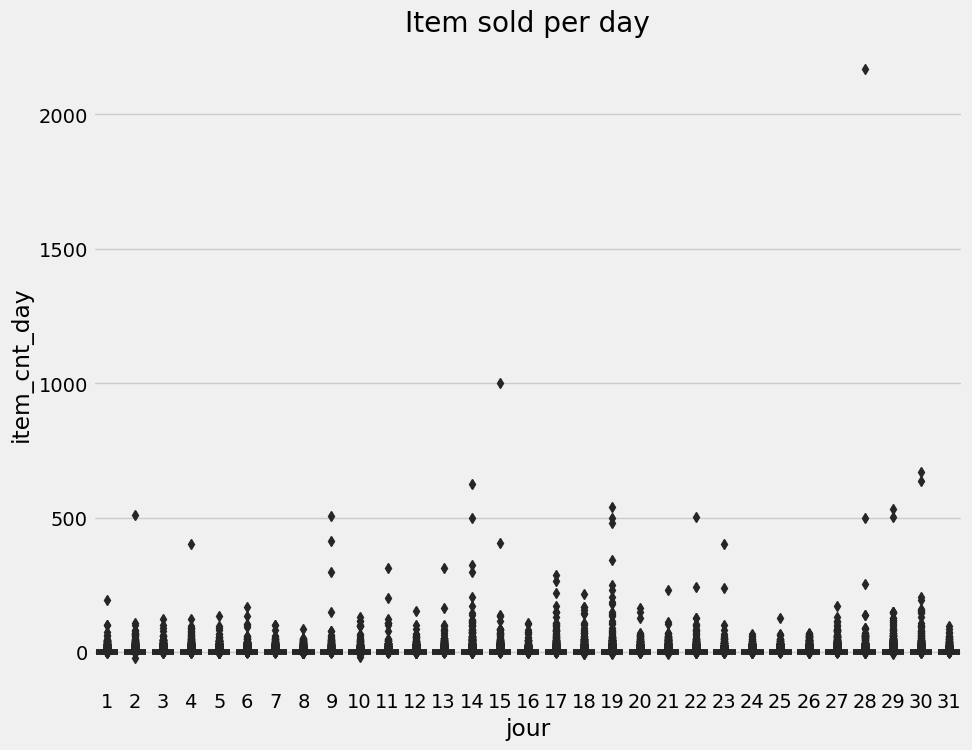

In [60]:
df_train['jour'] = df_train['date'].dt.day 
custom_colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow']
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_train, x='jour', y='item_cnt_day', palette=custom_colors)
ax.set_title('Item sold per day')
plt.show()

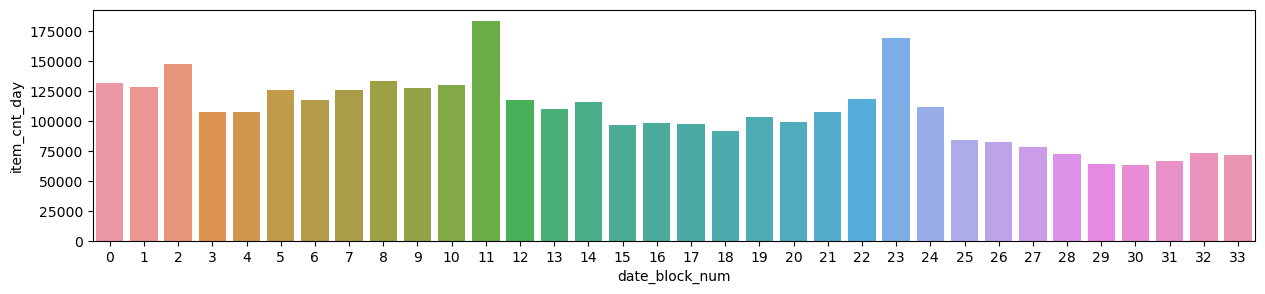

In [12]:
# month wise selling 

df_train_3 = df_train.groupby(['date_block_num'], as_index=False)['item_cnt_day'].sum()
plt.figure(figsize=(15,3))
sns.barplot(x="date_block_num",y="item_cnt_day", data = df_train_3)
plt.show()

## Let's create our model :

In [3]:
def get_prices(item):
    item = pd.merge(item, df_train[['item_id','item_price']], on = 'item_id',how = 'left')
    return item 

items = get_prices(items)

In [4]:
def feature_engineering_train(df): 
    df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
    df['jour'] = df['date'].dt.day
    df['mois'] = df['date'].dt.month
    df['annee'] = df['date'].dt.year
    df = pd.merge(df, items[['item_id', 'item_category_id']], on='item_id', how='left')
    df = df.dropna()
    
    test_shop = df_test['shop_id'].unique()
    test_item = df_test['item_id'].unique()
    # Only shops that exist in test data
    df = df[df['shop_id'].isin(test_shop)]
    # Only items that exist in test data
    df = df[df['item_id'].isin(test_item)]
    return df



train  = feature_engineering_train(df_train)
train.shape

: 

: 

In [6]:
def feature_engineering_test(df): 
    df = pd.merge(df, items[['item_id', 'item_category_id','item_price']], on='item_id', how='left')
    df = df.dropna()
    return df 

test = feature_engineering_test(df_test)

In [51]:
# création des features 
def feature_creation(df):
    FEATURES = [
    'shop_id',
    'item_id',
    'item_price',
    'item_category_id'
    ]

    TARGET =  'item_cnt_day'

    return FEATURES, TARGET 

FEATURES, TARGET = feature_creation(df_train)

# TimeSeriesSplit 
tss = TimeSeriesSplit(n_splits=4, test_size=24*365*1, gap=24) 

X_train, y_train = train[FEATURES], train[FEATURES], train[TARGET], test[TARGET]

model = XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

model.fit(X_train, y_train, 
eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)
    


In [11]:
df

Index(['ID', 'shop_id', 'item_id', 'item_category_id', 'item_price'], dtype='object')

In [66]:
df_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,jour,mois,annee
0,2013-01-02,0,59,22154,999.00,1.0,2,1,2013
1,2013-01-03,0,25,2552,899.00,1.0,3,1,2013
2,2013-01-05,0,25,2552,899.00,-1.0,5,1,2013
3,2013-01-06,0,25,2554,1709.05,1.0,6,1,2013
4,2013-01-15,0,25,2555,1099.00,1.0,15,1,2013
...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,10,10,2015
2935845,2015-10-09,33,25,7460,299.00,1.0,9,10,2015
2935846,2015-10-14,33,25,7459,349.00,1.0,14,10,2015
2935847,2015-10-22,33,25,7440,299.00,1.0,22,10,2015


In [13]:
sales

NameError: name 'sales' is not defined